In [14]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from src.utils import *

# Generate data

In [16]:
#episodes = generate_episodes_from_all_models(episode_length=200, episodes_per_param=50)

In [17]:
#episodes.shape

(np.float64(0.002487856107886821), np.float64(14.992176637208082), (948, 100))

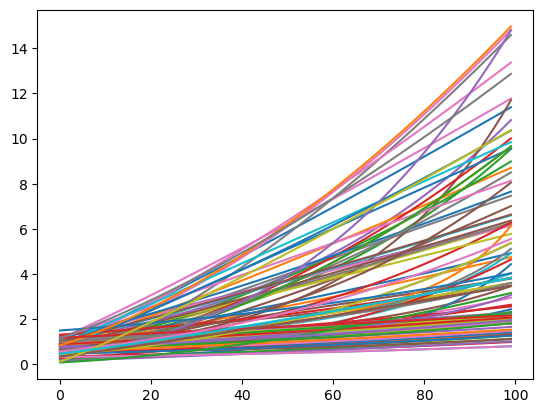

In [18]:
episode_length = 100
episodes_per_param = 20
paris_episodes = np.empty((0, episode_length))
for c in np.arange(0.01, .1, .02):
    for m in np.arange(0.01, 4, .2):
        paris = ParisLawDegradation(length=episode_length, dim=1, c=c, m=m)
        episodes_i = paris.generate_episode(x0=np.abs(np.random.randn(episodes_per_param)*0.3+0.7))  # Initial crack lengths in meters
        paris_episodes = np.concatenate([paris_episodes, episodes_i], axis=0)

#drop invalid values
paris_episodes = paris_episodes[~np.isnan(paris_episodes).any(axis=1)]
paris_episodes = paris_episodes[(paris_episodes<15).all(axis=1)]
paris_episodes = paris_episodes[(paris_episodes>=0).all(axis=1)]

paris_episodes.shape
# plot 20 random episodes
plt.plot(paris_episodes[np.random.randint(0, paris_episodes.shape[0], size=100)].T)
paris_episodes.min(), paris_episodes.max(), paris_episodes.shape

(np.float64(0.002560219746124859), np.float64(11.311745431849216), (1000, 100))

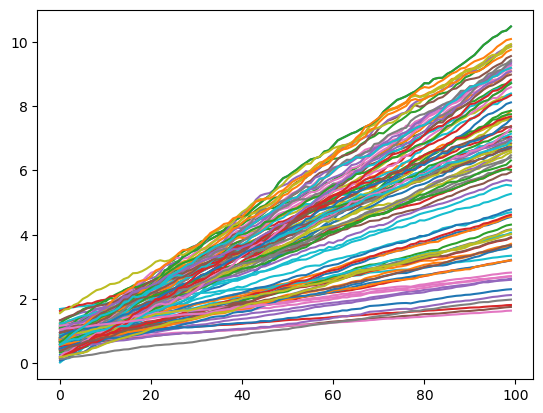

In [19]:
lin_episodes = np.empty((0, episode_length))
for c in np.linspace(0.01, 0.1, 50):
    
    lin = LinearDegradation(length=episode_length, dim=1, c=c, mu_e=0, sigma_e=c/2)
    episodes_i = lin.generate_episode(x0=np.abs(np.random.randn(episodes_per_param)*0.3+0.7))  # Initial crack lengths in meters
    lin_episodes = np.concatenate([lin_episodes, episodes_i], axis=0)

#drop invalid values
lin_episodes = lin_episodes[~np.isnan(lin_episodes).any(axis=1)]
lin_episodes = lin_episodes[(lin_episodes<15).all(axis=1)]
lin_episodes = lin_episodes[(lin_episodes>=0).all(axis=1)]

# plot 20 random episodes
plt.plot(lin_episodes[np.random.randint(0, lin_episodes.shape[0], size=100)].T)
lin_episodes.min(), lin_episodes.max(), lin_episodes.shape

(np.float64(0.012991485300515304), np.float64(13.359466885592704), (480, 100))

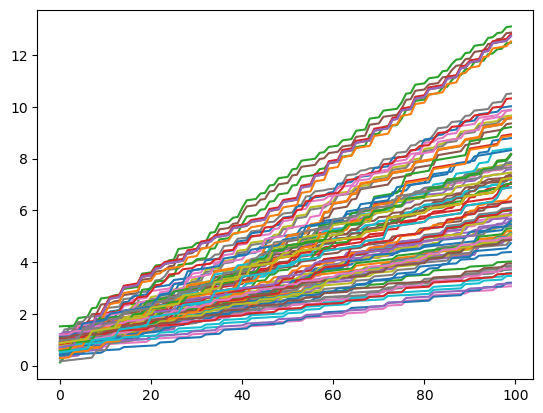

In [20]:
shock_episodes = np.empty((0, episode_length))
for mu_t in range(2, 7):
    for mu_shock in np.linspace(0.1, 0.3, 5):
        shock = RandomShockDegradation(length=episode_length, dim=1, 
                                       mu_t=mu_t, sigma_t=mu_t/3, 
                                       mu_shock=mu_shock, sigma_shock=mu_shock/3, 
                                       baseline=mu_shock/10)
        
        episodes_i = shock.generate_episode(x0=np.abs(np.random.randn(episodes_per_param)*0.3+0.7))  # Initial crack lengths in meters
        shock_episodes = np.concatenate([shock_episodes, episodes_i], axis=0)

#drop invalid values
shock_episodes = shock_episodes[~np.isnan(shock_episodes).any(axis=1)]
shock_episodes = shock_episodes[(shock_episodes<15).all(axis=1)]
shock_episodes = shock_episodes[(shock_episodes>=0).all(axis=1)]

shock_episodes.shape
# plot 20 random episodes
plt.plot(shock_episodes[np.random.randint(0, shock_episodes.shape[0], size=100)].T)
shock_episodes.min(), shock_episodes.max(), shock_episodes.shape

(np.float64(0.016076733765137297), np.float64(14.988955272589765), (1056, 100))

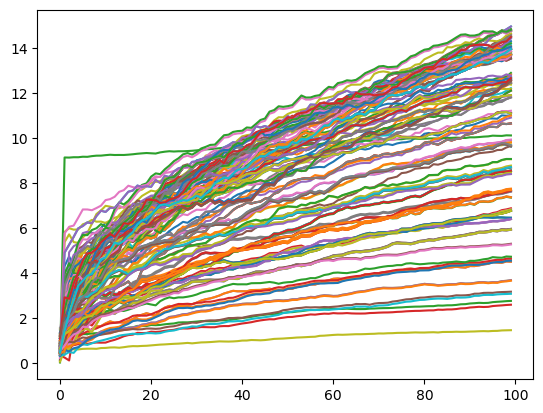

In [21]:
sei_episodes = np.empty((0, episode_length))
for k in np.linspace(0.01, 2, 100):
    
    sei = SEILayer(length=episode_length, dim=1, k=k, sigma_e=1)
    
    episodes_i = sei.generate_episode(x0=np.abs(np.random.randn(episodes_per_param)*0.3+0.7))  # Initial crack lengths in meters
    sei_episodes = np.concatenate([sei_episodes, episodes_i], axis=0)

#drop invalid values
sei_episodes = sei_episodes[~np.isnan(sei_episodes).any(axis=1)]
sei_episodes = sei_episodes[(sei_episodes<15).all(axis=1)]
sei_episodes = sei_episodes[(sei_episodes>=0).all(axis=1)]

sei_episodes.shape
# plot 20 random episodes
plt.plot(sei_episodes[np.random.randint(0, sei_episodes.shape[0], size=200)].T)
sei_episodes.min(), sei_episodes.max(), sei_episodes.shape

(np.float64(0.015148284485826155), np.float64(14.993687738184356), (166, 100))

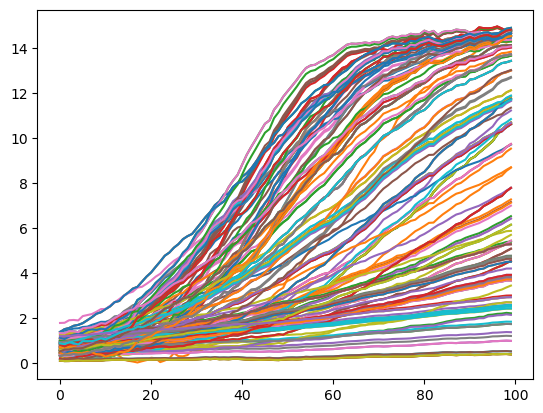

In [22]:
logistic_episodes = np.empty((0, episode_length))
for alfa in np.linspace(0.01, .4, 40):
    
    logstiff = LogisticStiffness(length=episode_length, dim=1, alfa=alfa, xmax=15, sigma_e=alfa)
    
    episodes_i = logstiff.generate_episode(x0=np.abs(np.random.randn(episodes_per_param)*0.3+0.7))  # Initial crack lengths in meters
    logistic_episodes = np.concatenate([logistic_episodes, episodes_i], axis=0)

#drop invalid values
logistic_episodes = logistic_episodes[~np.isnan(logistic_episodes).any(axis=1)]
logistic_episodes = logistic_episodes[(logistic_episodes<15).all(axis=1)]
logistic_episodes = logistic_episodes[(logistic_episodes>=0).all(axis=1)]

logistic_episodes.shape
# plot 20 random episodes
plt.plot(logistic_episodes[np.random.randint(0, logistic_episodes.shape[0], size=200)].T)
logistic_episodes.min(), logistic_episodes.max(), logistic_episodes.shape

(np.float64(0.0003048981919687582), np.float64(14.649215148669267), (591, 100))

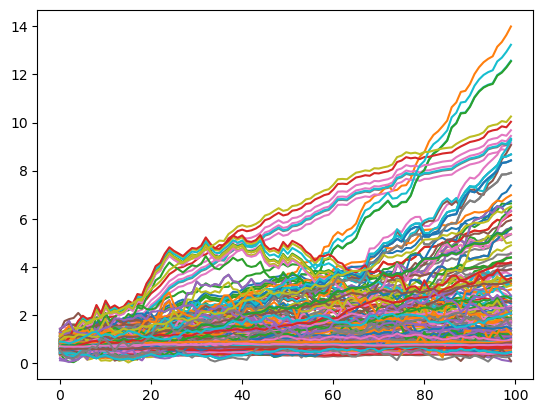

In [23]:
loglogistic_episodes = np.empty((0, episode_length))
for beta in np.linspace(0.01, .3, 8):
    for k in np.linspace(-0.9, .9, 8):
    
        logstiff = LogLogisticStiffness(length=episode_length, dim=1, alfa=15, beta=beta, k=k, sigma_e=beta)
        
        episodes_i = logstiff.generate_episode(x0=np.abs(np.random.randn(episodes_per_param)*0.3+0.7))  # Initial crack lengths in meters
        loglogistic_episodes = np.concatenate([loglogistic_episodes, episodes_i], axis=0)

#drop invalid values
loglogistic_episodes = loglogistic_episodes[~np.isnan(loglogistic_episodes).any(axis=1)]
loglogistic_episodes = loglogistic_episodes[(loglogistic_episodes<15).all(axis=1)]
loglogistic_episodes = loglogistic_episodes[(loglogistic_episodes>=0).all(axis=1)]

loglogistic_episodes.shape
# plot 20 random episodes
plt.plot(loglogistic_episodes[np.random.randint(0, loglogistic_episodes.shape[0], size=200)].T)
loglogistic_episodes.min(), loglogistic_episodes.max(), loglogistic_episodes.shape

In [24]:
episodes = np.concatenate([lin_episodes, shock_episodes, paris_episodes, sei_episodes, logistic_episodes, loglogistic_episodes], axis=0)

In [25]:

# Check default device
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
#device = torch.device('cpu')  # Force CPU for consistency in this example
print("Default Device:", device)

Default Device: mps


In [26]:
print(f"Min: {episodes.min()}")
print(f"Max: {episodes.max()}")

Min: 0.0003048981919687582
Max: 14.993687738184356


# Set up model and training params

In [27]:
vocab_size=1000
context_window=40
bs = 32
# Split episodes into train/test (e.g., 80/20)
# Shuffle indices
shuffled_indices = np.random.permutation(len(episodes))

# Apply shuffled indices
shuffled_episodes = episodes[shuffled_indices]

n_train = int(0.8 * len(episodes))
train_episodes = shuffled_episodes[:n_train]
test_episodes = shuffled_episodes[n_train:]
train_dataset = TimeSeriesDataset(train_episodes, context_window=context_window, vocab_size=vocab_size)
test_dataset = TimeSeriesDataset(test_episodes, context_window=context_window, vocab_size=vocab_size)
len(train_dataset), len(test_dataset)

(203520, 50940)

In [28]:
train_episodes.shape, test_episodes.shape

((3392, 100), (849, 100))

In [29]:
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, pin_memory=True, num_workers=2)
len(train_loader), len(test_loader)

(6360, 1592)

In [30]:
model = DegradationTransformer(vocab_size=vocab_size, context_window=context_window, 
                               embedding_dim=64, num_heads=8, num_blocks=3)
# model param count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 215,744 trainable parameters


In [31]:
# get lr form learner


In [32]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()
len(train_loader), len(test_loader)
cbs = [ProgressCallback(50), SaveModel()]
learner = Learner(model, optim, loss_func, train_loader, test_loader, cbs, device=device)
learner.fit(1)

KeyboardInterrupt: 

In [33]:
example_input = torch.randn(
    1, learner.model.context_window,
    device=device
)
# make example_input of type long
example_input = example_input.long()
# Generate example output (forward pass, no grad)
with torch.no_grad():
    example_output = learner.model(example_input)

In [ ]:
example_input, example_output.shape

NameError: name 'example_input' is not defined

# Model evaluation

In [4]:
oo=0.0
oo==0

True

In [35]:
# Pick a random test sample
FUTURE_WINDOW = 60
test_idx = np.random.randint(0, lin_episodes.shape[0], size=1)
x_context = test_episodes[test_idx, :context_window]
y_true = test_episodes[test_idx, context_window:context_window+FUTURE_WINDOW]

# Predict
y_pred,log_probs = learner.predict(x_context, num_periods=FUTURE_WINDOW, temperature=0.0, grad=True, return_tensor=True) # Greedy for eval

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(context_window), x_context.T, 'k-', label='Context')
plt.plot(np.arange(context_window, context_window+FUTURE_WINDOW), y_true.T, 'g--', label='Ground Truth')
plt.plot(np.arange(context_window, context_window+FUTURE_WINDOW), y_pred.T, 'r-', label='Transformer Prediction')
plt.legend()
plt.title("Prediction after RLHF")
plt.show()

np.save('degradation_episodes.npy', test_episodes[test_idx,:context_window])

: 

In [ ]:
log_probs

NameError: name 'log_probs' is not defined

## next token prediction accuracy

In [ ]:
class TimeSeriesDatasetRaw(torch.utils.data.Dataset):
    def __init__(self, data, context_window, vocab_size):
        self.data = data
        self.context_window = context_window
        self.vocab_size = vocab_size
        self.n_episodes, self.episode_length = data.shape
        self.samples_per_episode = self.episode_length - context_window
        self.normalizer = WindowNormalizer()
        self.digitizer = UniformDigitizer(vocab_size)
    def __len__(self):
        return self.n_episodes * self.samples_per_episode
    
    def __getitem__(self, idx):
        

        idx_array = np.atleast_1d(idx)
        single_sample = np.isscalar(idx)

        episode_idx = idx_array // self.samples_per_episode
        pos = idx_array % self.samples_per_episode

        # Correct slicing for variable positions
        x = np.stack([self.data[e, p:p+self.context_window] for e, p in zip(episode_idx, pos)])
        y = np.array([self.data[e, p+self.context_window] for e, p in zip(episode_idx, pos)])

        # Convert to tensors
        x_tensor = torch.tensor(x, dtype=torch.float)
        y_tensor = torch.tensor(y, dtype=torch.float).squeeze()

        if single_sample:
            x_tensor = x_tensor[0]
            y_tensor = y_tensor[0]

        return x_tensor, y_tensor




In [ ]:
train_episodes.shape, test_episodes.shape

((3353, 100), (839, 100))

In [ ]:
import plotly.express as px
import pandas as pd

In [ ]:
dataset_raw= TimeSeriesDatasetRaw(train_episodes, context_window=context_window, vocab_size=vocab_size)
x_batch, y_batch = dataset_raw[range(5_000)]


print(x_batch.shape)

y_predict = learner.predict(x_batch, num_periods=1)[0][:, -1]




df=pd.DataFrame([y_batch, y_predict]).T
df.columns = ['True Value', 'Predicted Value']
fig = px.line(df, labels={ 'x':['Predicted Value','Predicted Value']}, title='Train data - Next Token Prediction Accuracy')
fig.show()

torch.Size([5000, 40])


does the plot above means we need a bit of regularization, it seems we are fitting to noise??

we are also overfitting to the near-zero scienarios, most of which are paris episodes??!


Text(0.5, 1.0, 'Train data - Next Token Prediction Accuracy')

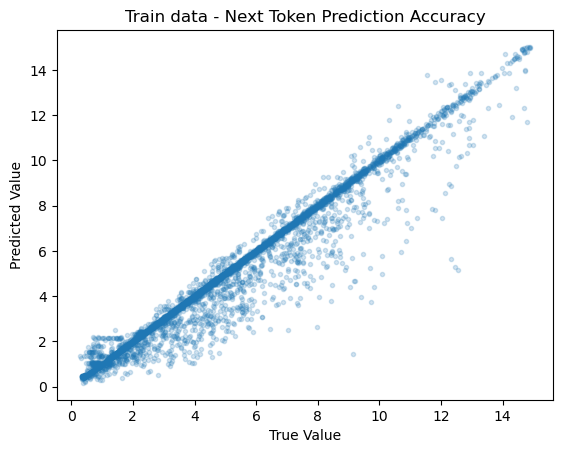

In [ ]:
plt.plot(y_batch, y_predict, '.', alpha=0.2)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Train data - Next Token Prediction Accuracy')

In [ ]:
dataset_raw= TimeSeriesDatasetRaw(test_episodes, context_window=context_window, vocab_size=vocab_size)
x_batch, y_batch = dataset_raw[range(5_000)]


print(x_batch.shape)

y_predict = learner.predict(x_batch, num_periods=1)[0][:, -1]


df=pd.DataFrame([y_batch, y_predict]).T
df.columns = ['True Value', 'Predicted Value']
fig = px.line(df, labels={ 'x':['Predicted Value','Predicted Value']}, title='Test data - Next Token Prediction Accuracy')
fig.show()

torch.Size([5000, 40])


Text(0, 0.5, 'Predicted Value')

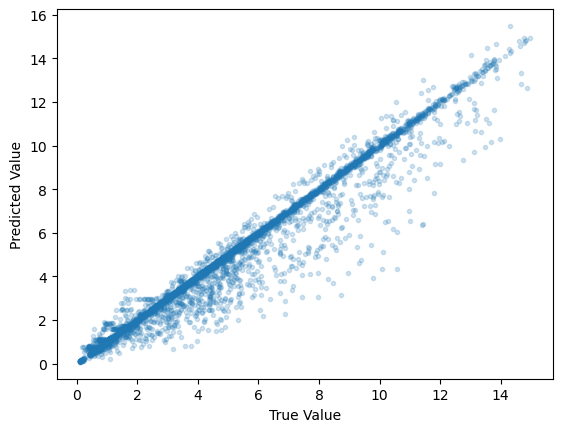

In [ ]:
plt.plot(y_batch, y_predict, '.', alpha=0.2)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')

# test model loading from local file

In [ ]:
from safetensors.torch import load_model
import json
with open("degradation_transformer_model_config.json", "rb") as f:
    model_params=json.load(f)

model1 = DegradationTransformer(vocab_size=model_params['vocab_size'], 
                                context_window=model_params['context_window'], 
                               embedding_dim=model_params['embedding_dim'], 
                               num_heads=model_params['num_heads'],
                                 num_blocks=model_params['num_blocks'])
load_model(model1, "degradation_transformer_model.safetensors")
model1.eval()
learner1 = Learner(model1, optim=None, loss_func=None, 
                  train_loader=None, test_loader=None, cbs=[])

y_predict = learner1.predict(x_batch, num_periods=1)[0][:, -1]


df=pd.DataFrame([y_batch, y_predict]).T
df.columns = ['True Value', 'Predicted Value']
fig = px.line(df, labels={ 'x':['Predicted Value','Predicted Value']}, title='Test data - Next Token Prediction Accuracy')
fig.show()

## test model load from wandb

In [ ]:
import wandb
import os
api = wandb.Api()
artifact = api.artifact('smasadzadeh-freelancer/degradation-transformer/degradation-transformer-model:Production')

artifact_dir = artifact.download()

safetensor_filename="degradation_transformer_model.safetensors"
config_filename="degradation_transformer_model_config.json"

model_weights_path = os.path.join(artifact_dir, safetensor_filename)
config_path = os.path.join(artifact_dir, config_filename)

# Load config and create model
model_params = json.load(open(config_path))
model3 = DegradationTransformer(**model_params)
load_model(model3, model_weights_path)

learner3 = Learner(model3, optim=None, loss_func=None, 
                  train_loader=None, test_loader=None, cbs=[])

y_predict = learner3.predict(x_batch, num_periods=1)[0][:, -1]



df=pd.DataFrame([y_batch, y_predict]).T
df.columns = ['True Value', 'Predicted Value']
fig = px.line(df, labels={ 'x':['Predicted Value','Predicted Value']}, title='Test data - Next Token Prediction Accuracy')
fig.show()

wandb:   2 of 2 files downloaded.  


# test model loading from hf

this could be a differnet model than what we train here before pushing code to github

In [ ]:
from huggingface_hub import hf_hub_download
file_path = hf_hub_download(
    repo_id="smasadzadeh/degradation-transformer",
    filename="degradation_transformer_model.safetensors"
)

config_file_path = hf_hub_download(
    repo_id="smasadzadeh/degradation-transformer",
    filename="degradation_transformer_model_config.json"
)



model_params = json.load(open(config_file_path, "rb"))
# import DegradationTransformer class from utils_file_path

model2 = DegradationTransformer(vocab_size=model_params['vocab_size'], 
                                context_window=model_params['context_window'], 
                               embedding_dim=model_params['embedding_dim'], 
                               num_heads=model_params['num_heads'],
                                 num_blocks=model_params['num_blocks'])
load_model(model2, file_path)


learner2 = Learner(model2, optim=None, loss_func=None, 
                  train_loader=None, test_loader=None, cbs=[])

y_predict = learner2.predict(x_batch, num_periods=1)[0][:, -1]



df=pd.DataFrame([y_batch, y_predict]).T
df.columns = ['True Value', 'Predicted Value']
fig = px.line(df, labels={ 'x':['Predicted Value','Predicted Value']}, title='Test data - Next Token Prediction Accuracy')
fig.show()

NameError: name 'json' is not defined